# Julia Tutorial
## Why Julia
Not all scientific code is vectorizable for easy writing with python.

### Example Problem
suppose we want to simulate the random variable $X$ with pdf $P(x) = 2x$ where $x\in[0,1]$, with Metropolis-Hastings, assuming you have access to a uniform random number generator.

In [122]:
using Random
rng = MersenneTwister(1234);

function target(x)
    if 0 <= x <= 1
        return 2x
    else
        return 0
    end
end

function proposal(x)
    return x + 0.1 * (rand(rng) - 0.5)
end

function metropolis(nsamples)
    samples = Float64[]
    curr = rand()
    for _ = 1:nsamples
        next = proposal(curr)
        accept_ratio = target(next) / target(curr)
        if rand(rng) < accept_ratio
            curr = next
        end
        push!(samples, curr)
    end
    return samples
end

n_samples = Int(1e7)

10000000

In [160]:
@time pdf = metropolis(1) # compile
@time pdf = metropolis(n_samples); # Much faster than python!

  0.000036 seconds (12 allocations: 304 bytes)


  2.474004 seconds (89.75 M allocations: 1.409 GiB, 5.62% gc time)


Also plots take less time (out of the box)

  0.376610 seconds (5.62 k allocations: 76.490 MiB)


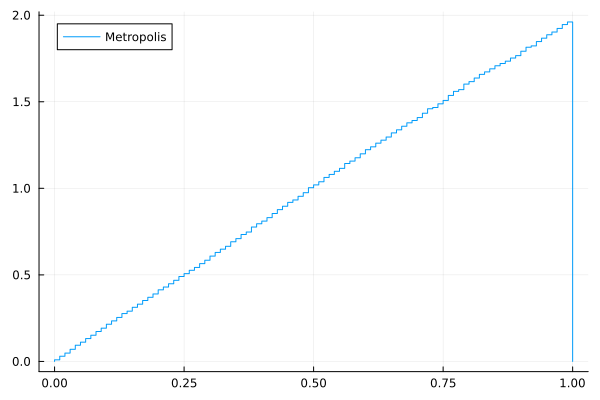

In [124]:
# plot histogram
using Plots
@time histogram(pdf, bins = 100, normed = true, label = "Metropolis")

## Assign variables

In [125]:
a = 42

42

In [126]:
b = 42;

you can use math symbols. personal opinion: readability takes a hit. This is because I'm a huge fan of descriptive names. Naming your variable `stopping_tolerance` is so much more descriptive than $\delta$.

In [127]:
γ = 1.4

1.4

but also emojis (if you want to torture anyone else who reads your code)

In [128]:
😺 = 3

3

In [129]:
typeof(😺)

Int64

### Getting help

In [130]:
# seems to only work in REPL
?typeof

ErrorException: syntax: invalid identifier name "?"

## Functions and structs

In [131]:
struct Point
    x::Int
    y
end

In [132]:
s = Point(1, 2.0)

Point(1, 2.0)

In [133]:
println("s.x: ", s.x, " s.y: ", s.y)

s.x: 1 s.y: 2.0


You can choose to or not choose to specify types

In [134]:
Point(3.5, 1.0) # raises error

InexactError: InexactError: Int64(3.5)

You can also add functions to construct the struct

In [135]:
Point() = Point(0, 0)
Point(x) = Point(x, 0)

function Point(x, y, z)
    println("last two arguments have been added")
    return Point(x, y+z)
end

Point

In [136]:
println(Point())
println(Point(3))
println(Point(3, 4, 5))

Point(0, 0)
Point(3, 0)
last two arguments have been added
Point(3, 9)


However you cannot change data after an (immutable) struct is constructed. You need to define an mutable struct

In [137]:
s = Point(3, 4)
s.x += 1 # raises error

ErrorException: setfield!: immutable struct of type Point cannot be changed

In [138]:
mutable struct MutablePoint
    x::Int
    y::Int
end # tip: specifying types for mutable structs helps with speed

In [139]:
m = MutablePoint(1, 2)
m.x += 1
println(m)

MutablePoint(2, 2)


### Types
Refer to [types](https://docs.julialang.org/en/v1/manual/types/) for more info.

Everything has a type, for example a 64 bit floating point number is `Float64`.
A struct is a composite type, it's made up of a collection of other types, example: `Complex128` is a struct made up of two `Float64`s. In general usually you don't need to specify types, because Julia will infer types and generate optimized code for you.

But specifying types is useful in some cases for performance (refer to [performance tips](https://docs.julialang.org/en/v1/manual/performance-tips/)) and also for ensuring correctness (at the cost of flexibility). 



### Abstract Types
How do you specify Float64 is a number?

```julia
abstract type Number end
abstract type Real     <: Number end
abstract type AbstractFloat <: Real end
abstract type Float64 <: AbstractFloat end
```

In [140]:
struct MyComplex128 <: Number
    re::Float64
    im::Float64
end

struct GeneralComplex{T <: Number}
    re::T
    im::T
end

In general complex we instantiated this with a parameter `T`, so if you want to do your calculations with a special 500 bit floating point number `Float500`, you can do complex arithmetic with GeneralComplex{Float500}. or If you feel like Float8s are enough, you can do GeneralComplex{Float8}.

A lot of this generalizability is useful under the hood. Ex: You can use arbitrary precision arithmetic with Julia's Differential equation solvers (which is shown in `useful_packages.ipynb`)

(so if you want to figure out whether your calculations are sensitive to numerical precision, you can just change the type of your numbers and see if the results change)

## Multiple dispatch
Julia chooses functions based on the types of the arguments. (Example from wikipedia)

In [141]:
abstract type SpaceObject end

struct Asteroid <: SpaceObject
    size::Int    
end
struct Spaceship <: SpaceObject
    size::Int                  
end

struct Astronaut <: SpaceObject
    size::Int
end

collide_with(::Asteroid, ::Spaceship) = "a/s"
collide_with(::Spaceship, ::Asteroid) = "s/a"
collide_with(::Spaceship, ::Spaceship) = "s/s"
collide_with(::Asteroid, ::Asteroid) = "a/a"
collide_with(::SpaceObject, ::SpaceObject) = "?"

collide(x::SpaceObject, y::SpaceObject) = (x.size > 100 && y.size > 100) ? "Big boom!" : collide_with(x, y);

In [142]:
collide(Asteroid(200), Spaceship(200))

"Big boom!"

In [143]:
collide(Astronaut(10), Astronaut(10))

"?"

In [144]:
collide(Spaceship(10), Spaceship(10))

"s/s"

In practice example from [DiffeqBase](https://github.com/SciML/DiffEqBase.jl/blob/782a88b91ea9f7fef5be19a913c8e323fbe87e37/src/internal_euler.jl#L15C1-L16C22)

```julia

function DiffEqBase.solve(prob::DiffEqBase.AbstractODEProblem{uType, tType, isinplace},
    Alg::FwdEulerAlg; args...)
```

the "solve" function specializes to problem and algorithm types

### Linear Algebra

In [145]:
using LinearAlgebra

In [146]:
A = [1 2 3; 4 5 6; 7 8 9]

3×3 Matrix{Int64}:
 1  2  3
 4  5  6
 7  8  9

In [147]:
A[2] # Julia is column major like fortran

4

In [148]:
A[1, 2]

2

In [149]:
A[1, :]

3-element Vector{Int64}:
 1
 2
 3

In [150]:
B = [1 2 3]

1×3 Matrix{Int64}:
 1  2  3

In [151]:
B = [1;2;3]

3-element Vector{Int64}:
 1
 2
 3

In [152]:
v = [1, 2, 3]

3-element Vector{Int64}:
 1
 2
 3

In [153]:
A[2]

4

In [154]:
# Solve A x = b
problem_dim = 4
b = rand(problem_dim)
A = rand(problem_dim, problem_dim)
A = A + A' # prime is the transpose operator

4×4 Matrix{Float64}:
 0.771712  1.45035  1.32655   0.897843
 1.45035   1.72862  1.30599   1.20739
 1.32655   1.30599  0.473387  0.917074
 0.897843  1.20739  0.917074  0.709644

In [155]:
@time x = A \ b

  0.000018 seconds (3 allocations: 384 bytes)


4-element Vector{Float64}:
 -0.31960971548891026
  3.431797274023509
 -0.5835681329914072
 -3.828164798331234

### Factorizations

In [156]:
Alu = lu(A)
Aqr = qr(A)

LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}, Matrix{Float64}}
Q factor:
4×4 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}, Matrix{Float64}}:
 -0.336326   0.83106    -0.327198   -0.298606
 -0.632087  -0.0759163   0.716701   -0.284679
 -0.578134  -0.521267   -0.615017   -0.125685
 -0.391296   0.178485    0.0321746   0.902217
R factor:
4×4 Matrix{Float64}:
 -2.29454  -2.80791   -1.90418   -1.87302
  0.0       0.608828   0.920219   0.303121
  0.0       0.0        0.240323   0.0303823
  0.0       0.0        0.0       -0.0868302

You can also do these "in-place" (i.e. without allocating new memory)

In [157]:
display(A)
s = lu!(A)
display(s)
display(A)

4×4 Matrix{Float64}:
 0.771712  1.45035  1.32655   0.897843
 1.45035   1.72862  1.30599   1.20739
 1.32655   1.30599  0.473387  0.917074
 0.897843  1.20739  0.917074  0.709644

LU{Float64, Matrix{Float64}, Vector{Int64}}
L factor:
4×4 Matrix{Float64}:
 1.0        0.0       0.0       0.0
 0.532089   1.0       0.0       0.0
 0.914644  -0.518478  1.0       0.0
 0.619054   0.258741  0.139307  1.0
U factor:
4×4 Matrix{Float64}:
 1.45035  1.72862    1.30599    1.20739
 0.0      0.530566   0.631649   0.255404
 0.0      0.0       -0.393628  -0.0548353
 0.0      0.0        0.0       -0.0962409

4×4 Matrix{Float64}:
 1.45035    1.72862    1.30599    1.20739
 0.532089   0.530566   0.631649   0.255404
 0.914644  -0.518478  -0.393628  -0.0548353
 0.619054   0.258741   0.139307  -0.0962409